In [1]:
RADIUS_ARCSEC = 0.2
import astropy.units as u
NICE_CSV = b"""ra,dec,Period
94.95546,-24.73952,0.12095
95.30235,-25.27431,0.12248
94.91626,-24.69648,0.12038
95.12418,-25.04329,0.23554
58.83506,-48.79122,0.56335
94.92264,-25.23185,0.07672
94.72086,-25.05767,0.17559
94.97073,-25.13643,0.12048
59.12997,-48.78522,0.11628
94.72086,-25.05767,0.17554
"""

In [2]:
# %pip install -U lsdb nested-pandas nested-dask hats 'dask[complete]'

In [9]:
from functools import partial
from io import BytesIO
from pathlib import Path

import numpy as np
import lsdb
import matplotlib.pyplot as plt
from nested_pandas import NestedDtype
import pandas as pd
from dask.distributed import Client

In [4]:
def cast_nested(df, columns):
    return df.assign(
        **{col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col])) for col in columns},
    )

In [5]:
release = 'w_2025_07'
hats_path = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats") / release

obj_catalog = lsdb.read_hats(hats_path / "object_lc").map_partitions(partial(cast_nested, columns=["forcedSource"]))
dia_catalog = lsdb.read_hats(hats_path / "diaObject_lc").map_partitions(partial(cast_nested, columns=["diaSource", "diaForcedSource"]))

nice_df = pd.read_csv(BytesIO(NICE_CSV)).reset_index()
nice_catalog = lsdb.from_dataframe(nice_df)
nice_catalog

,index,ra,dec,Period,Norder,Dir,Npix
npartitions=2,,,,,,,
"Order: 0, Pixel: 5",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 0, Pixel: 8",...,...,...,...,...,...,...


In [6]:
with Client(n_workers=20, threads_per_worker=1) as client:
    nice_obj = nice_catalog.crossmatch(obj_catalog, radius_arcsec=RADIUS_ARCSEC, suffixes=["_nice", ""]).compute()
    nice_dia = nice_catalog.crossmatch(dia_catalog, radius_arcsec=RADIUS_ARCSEC, suffixes=["_nice", ""]).compute()
print(nice_obj.shape, nice_dia.shape)
df = pd.merge(nice_obj, nice_dia, on="index_nice", suffixes=["_obj", "_dia"])

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-m78tkuwf', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-1wr_jw96', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-i7xx58q4', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-zmkryxsh', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-vhjtopk1', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-13aer144', purging
INFO:distributed.diskutils:Found stale lock f

(10, 86) (10, 19)


In [7]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

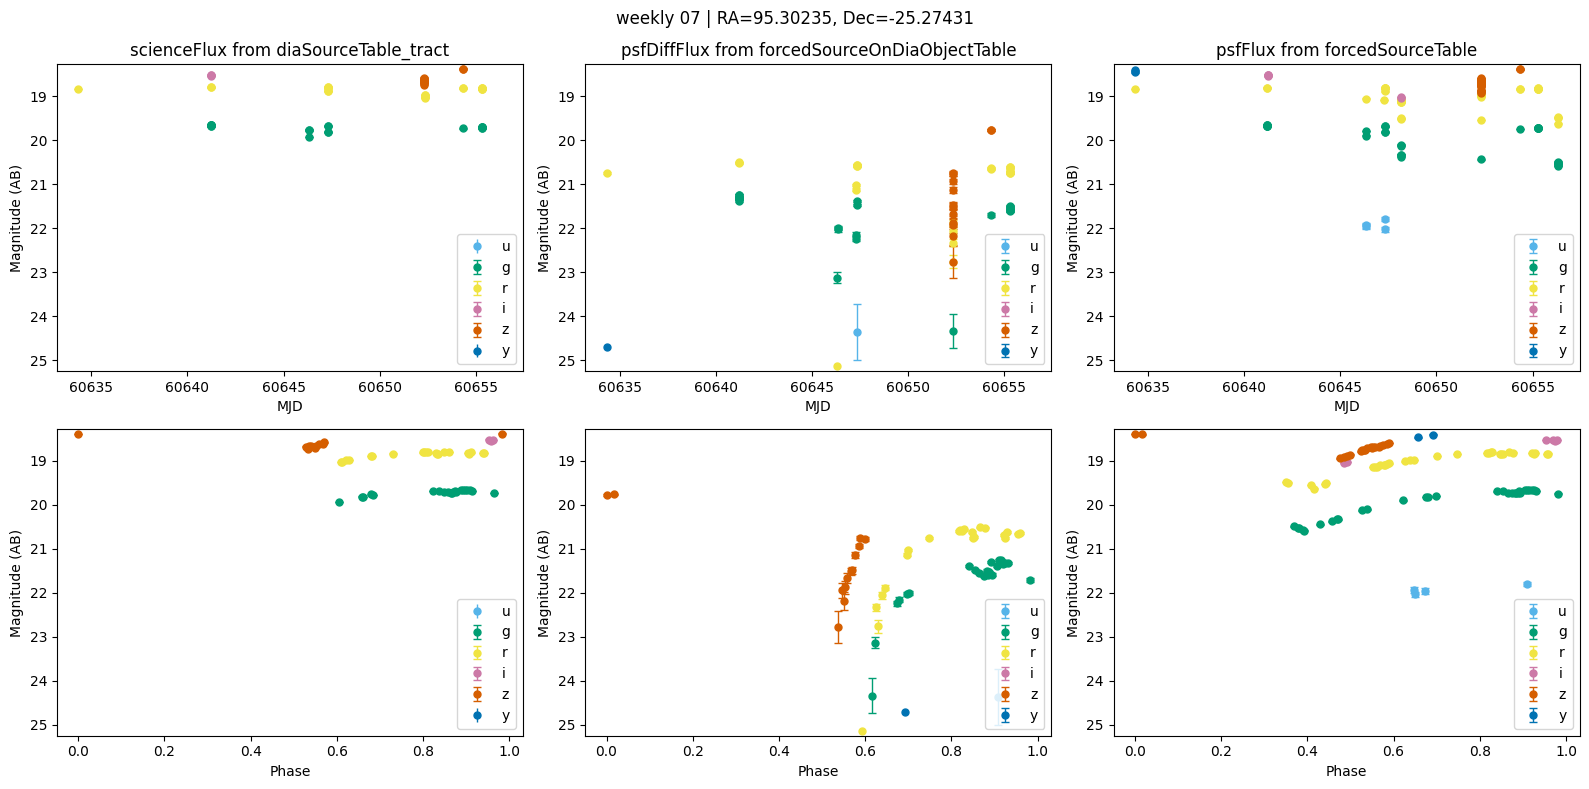

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

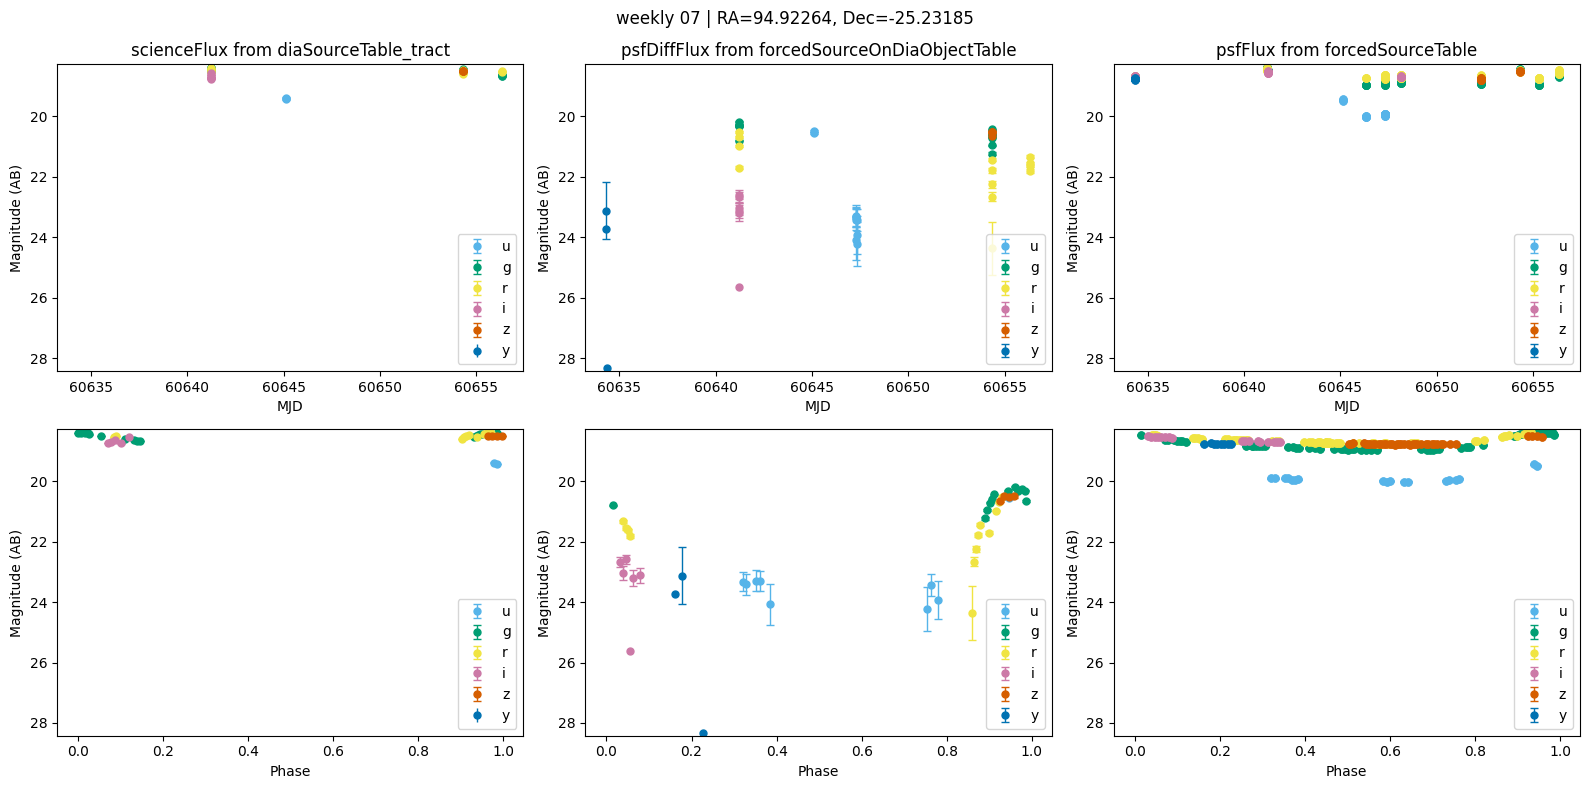

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

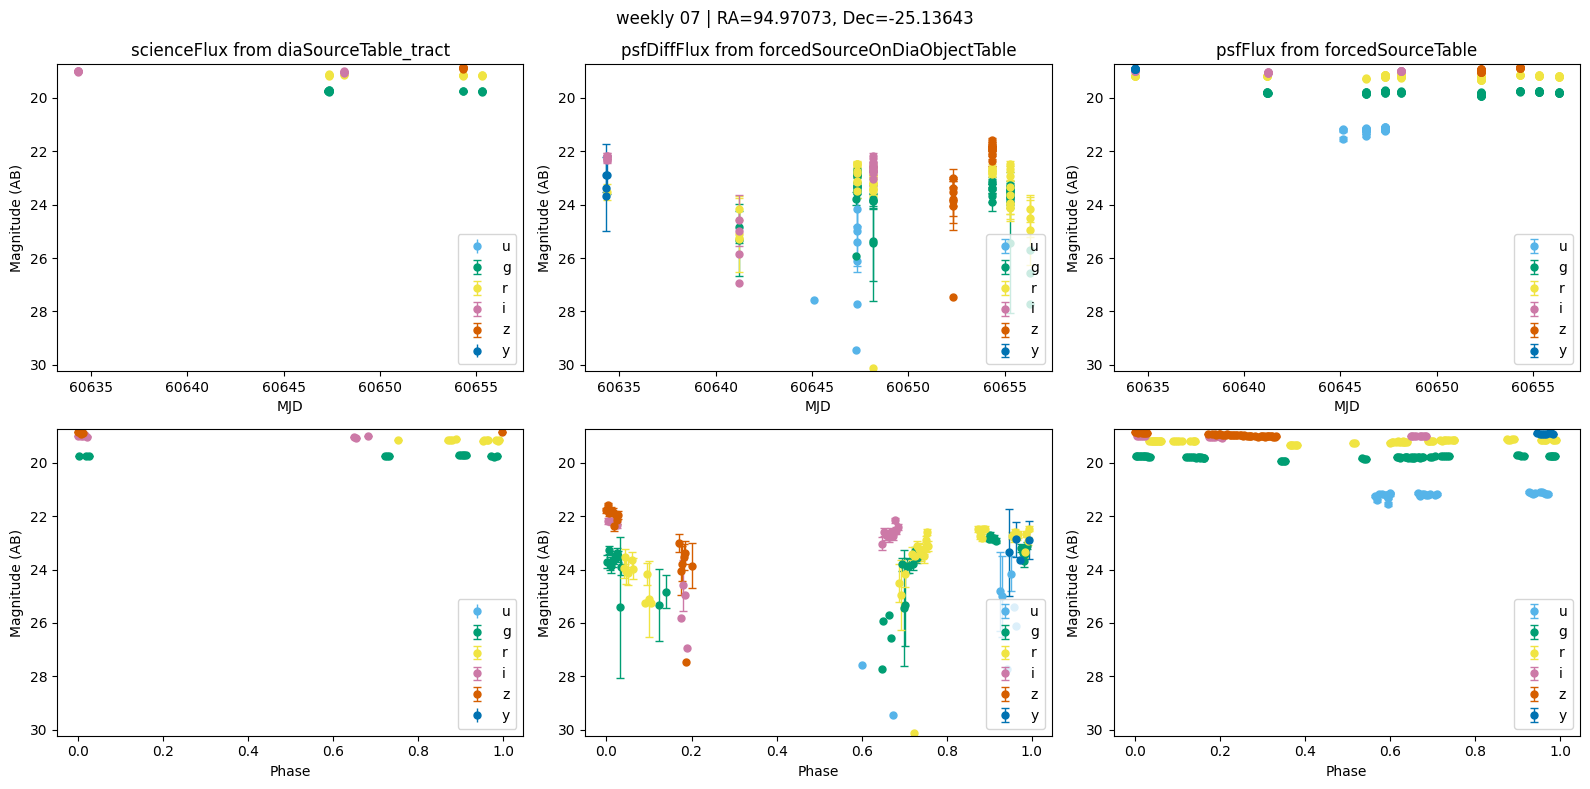

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

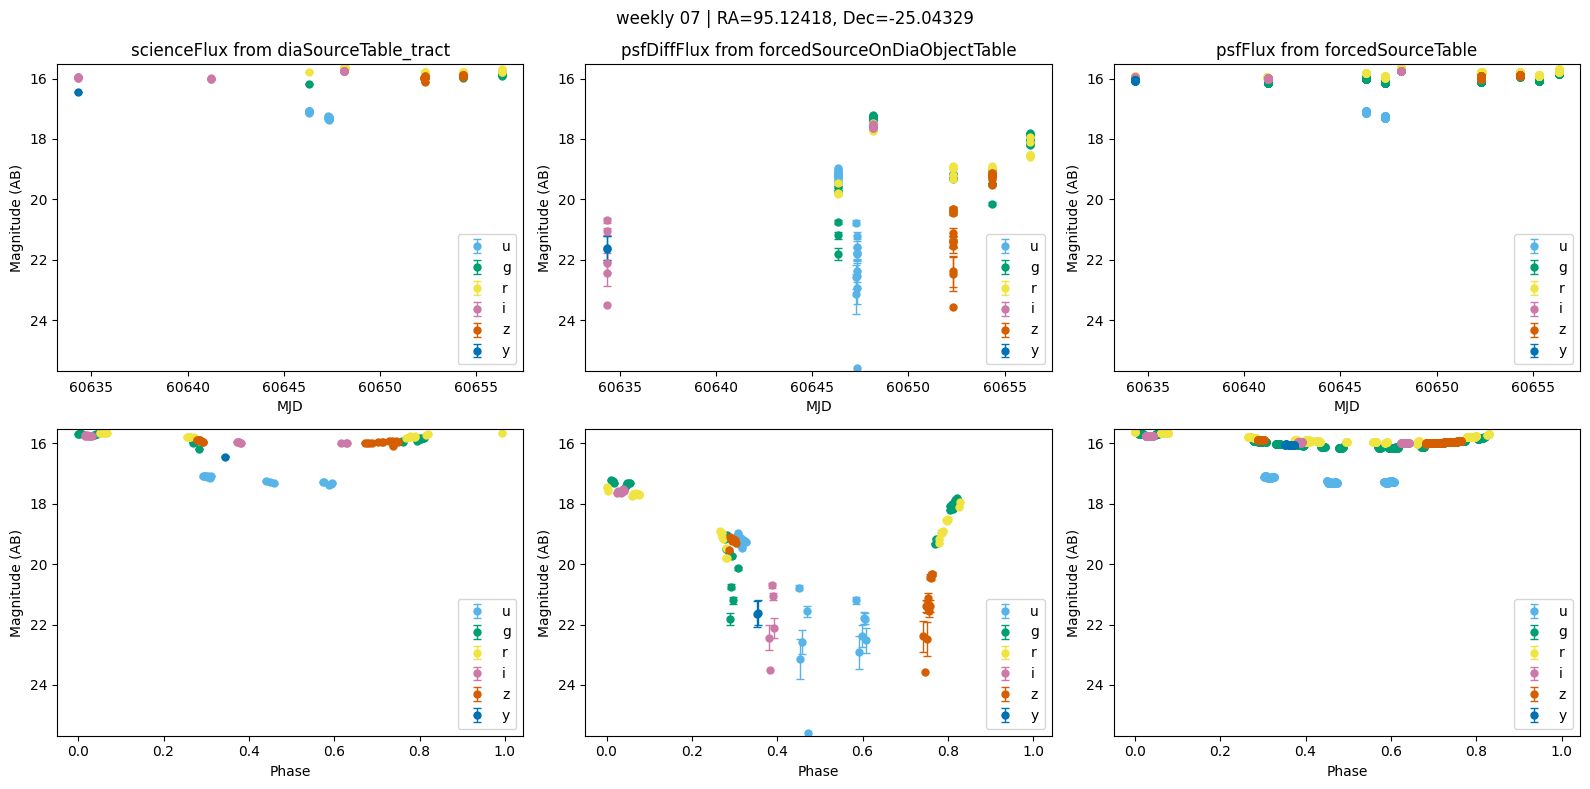

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

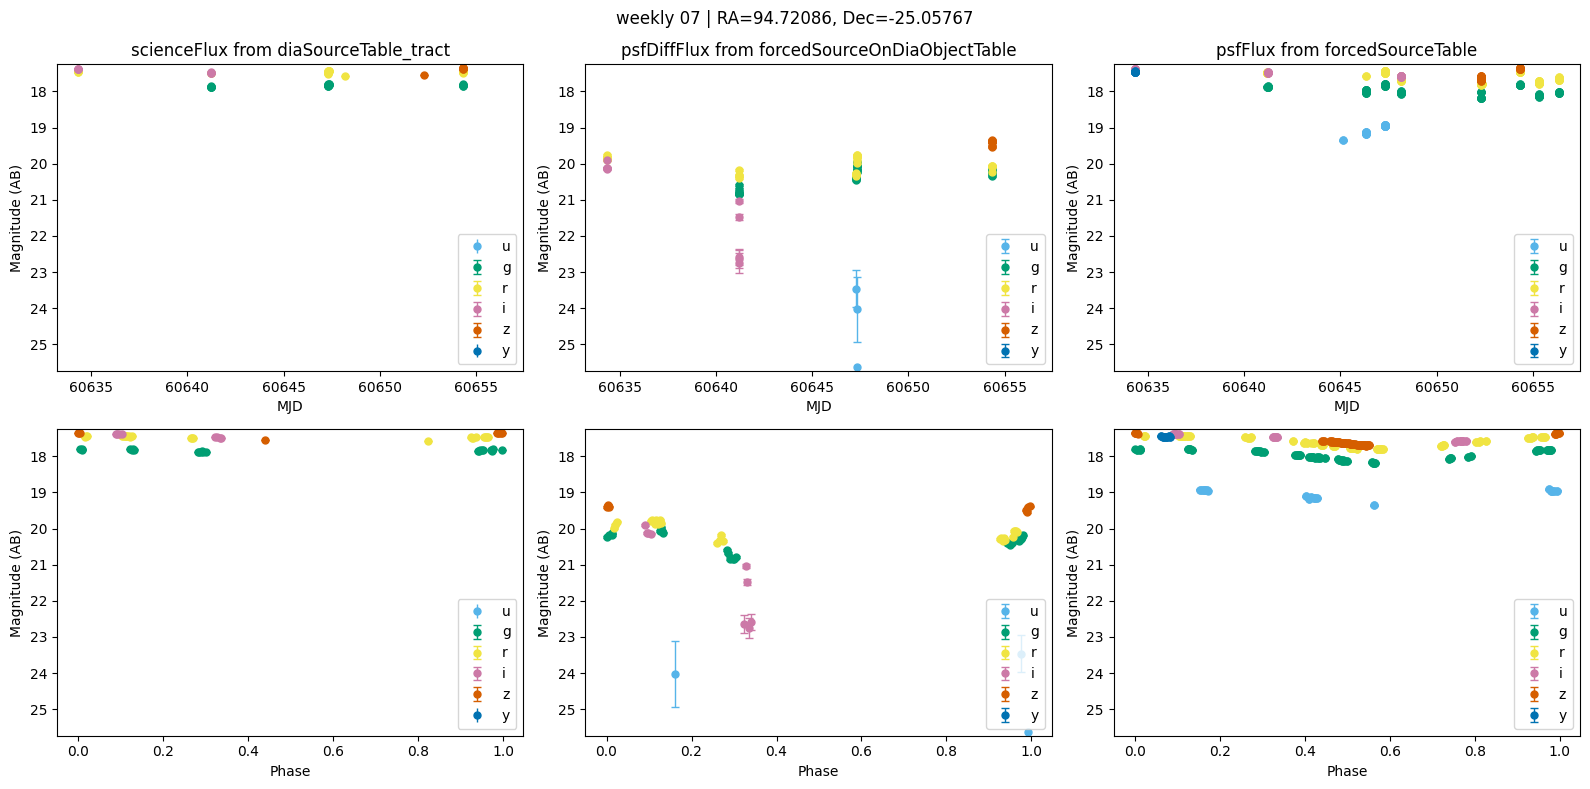

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

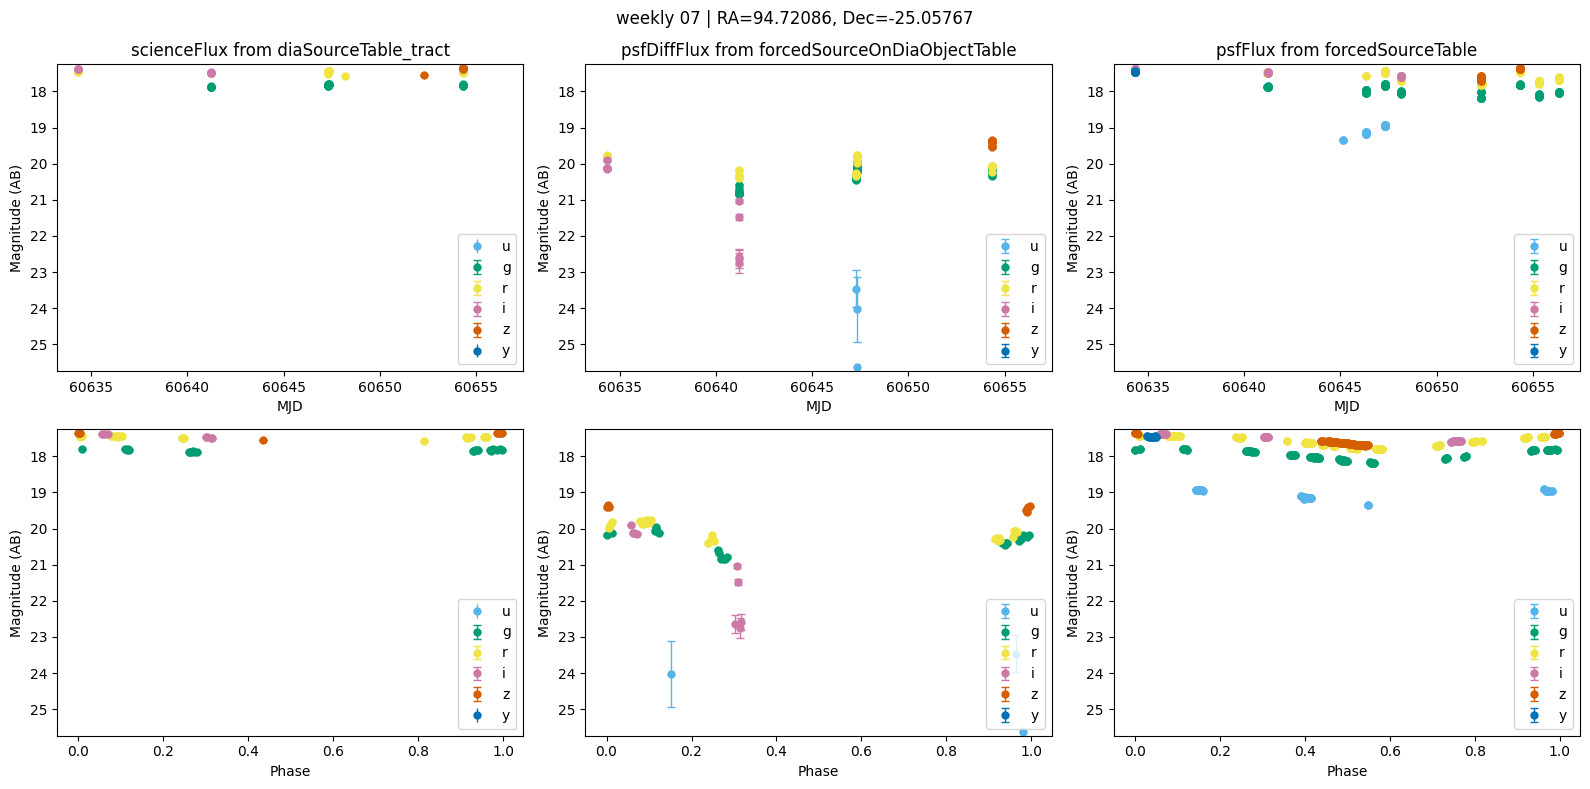

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

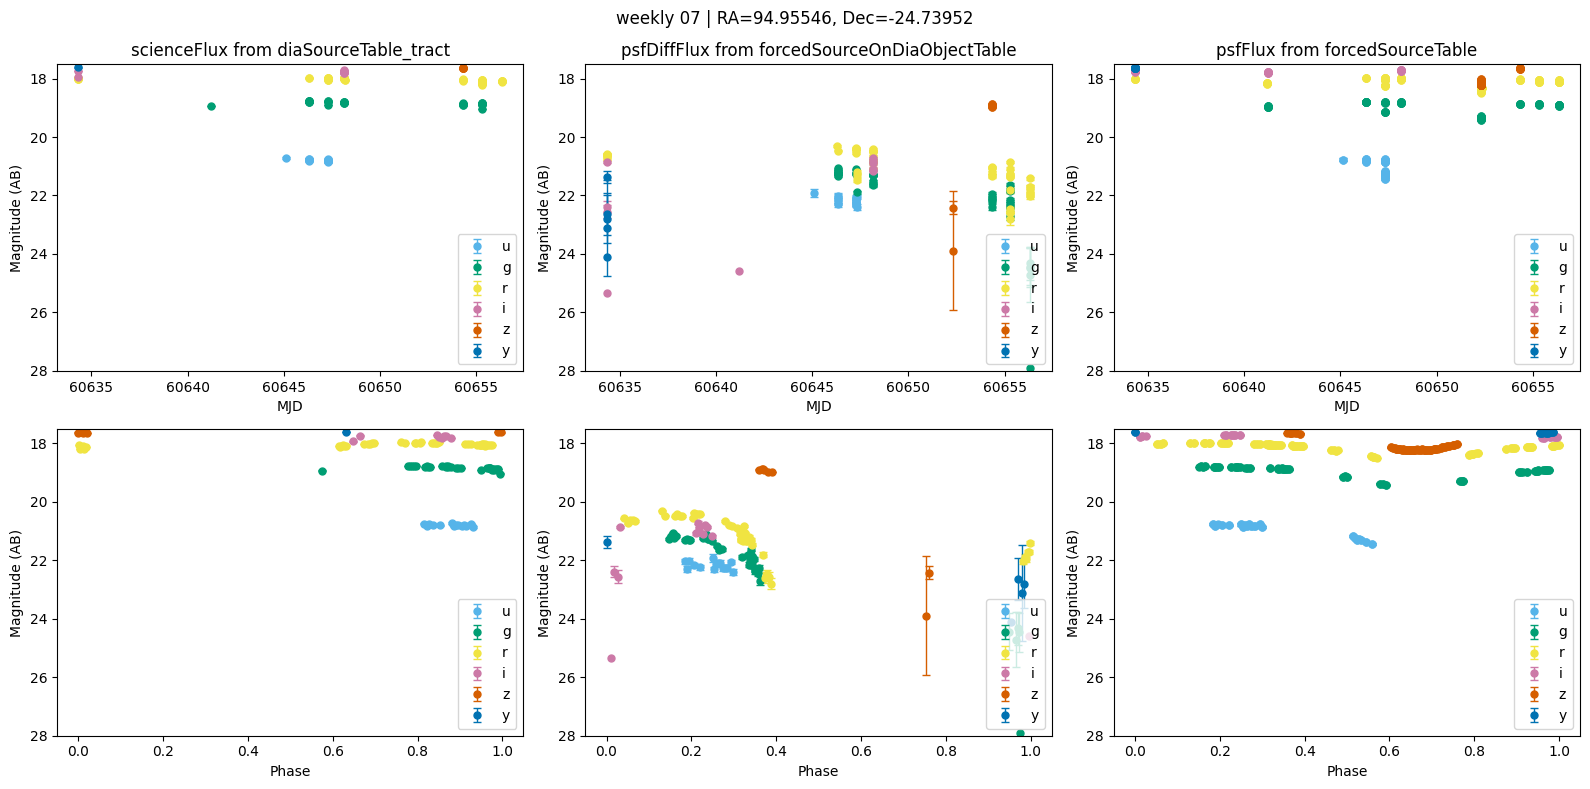

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

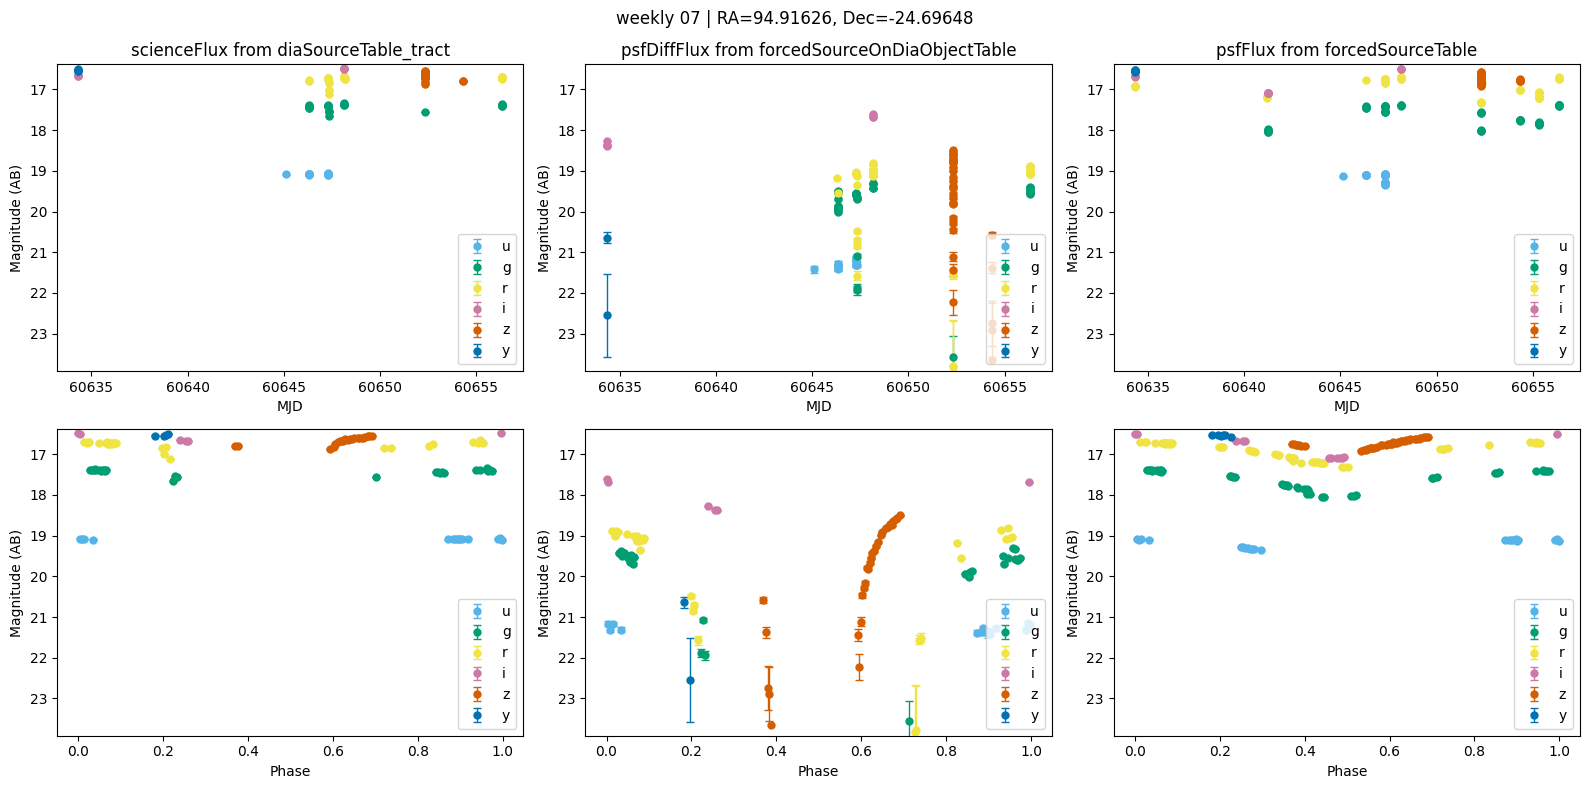

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

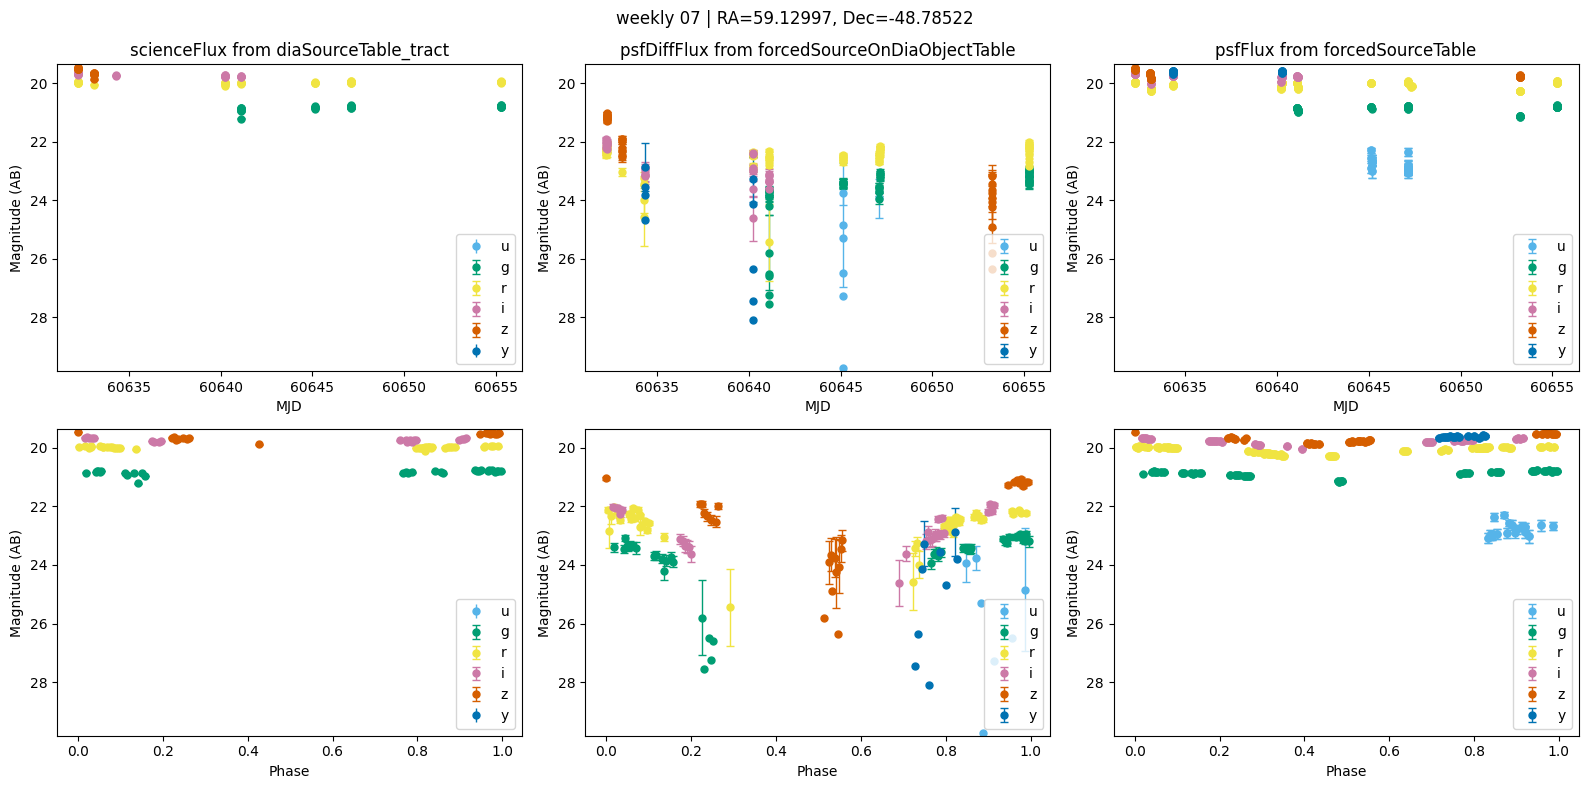

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value enco

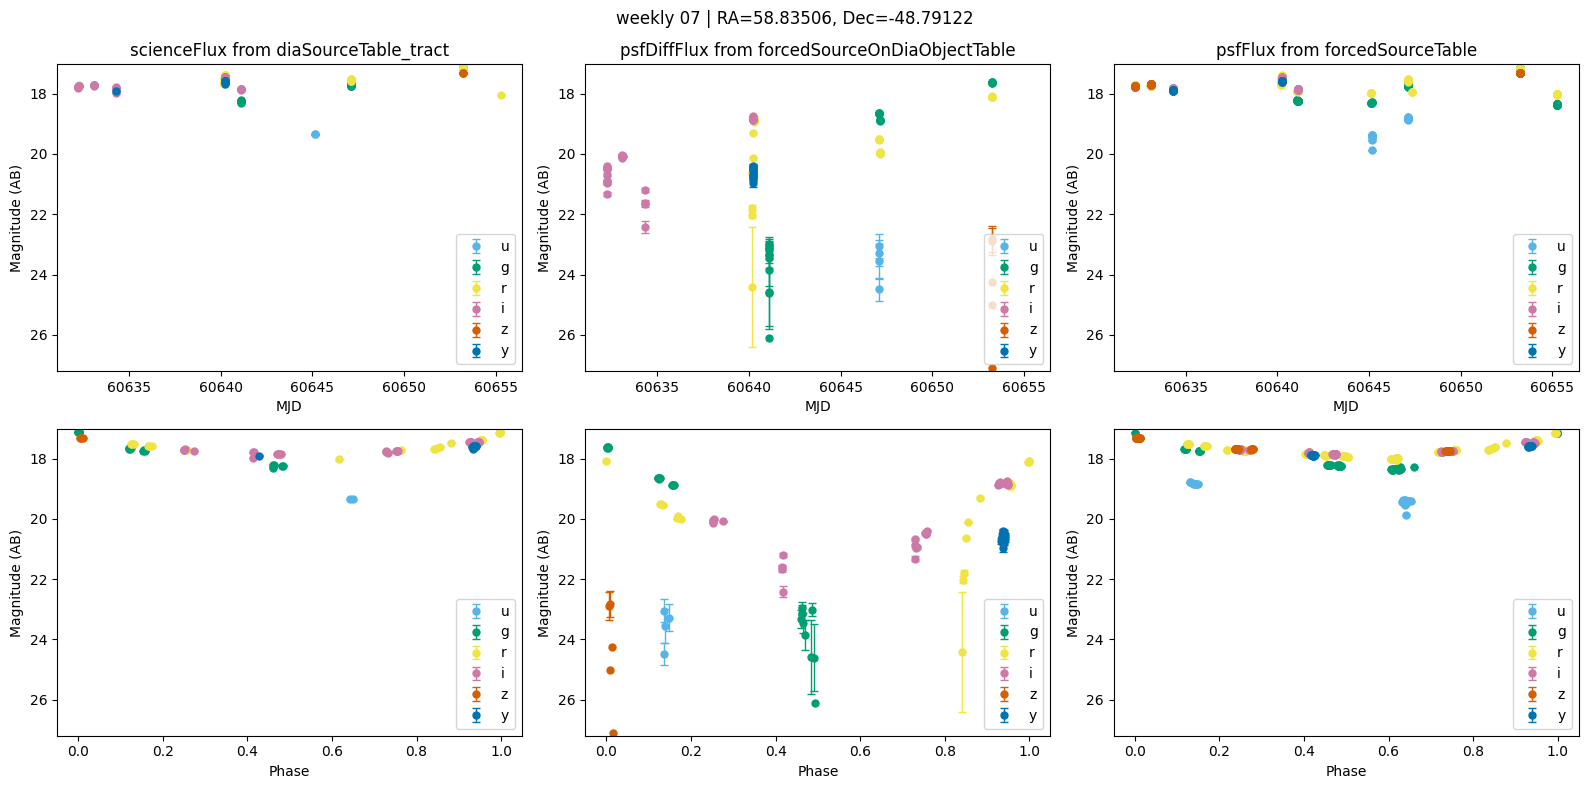

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

# Function to plot light curves in magnitude scale
def plot(ax, lc, flux_col, flux_err_col, x_name="midpointMjdTai", x_label="MJD"):
    lc = lc.query(
        "~psfFlux_flag"
        " and ~pixelFlags_saturated"
        " and ~pixelFlags_cr"
        " and ~pixelFlags_bad"
    )

    mag_values = []  # Store magnitudes for setting axis limits

    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        
        # Compute magnitudes and errors
        mag, magErr = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])

        ax.errorbar(
            band_lc[x_name], mag, magErr,
            fmt='o', label=band, color=color, alpha=1, markersize=5, capsize=3, elinewidth=1
        )

        mag_values.extend(mag.dropna().values)  # Collect magnitude values

    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()  # Magnitudes are plotted with brighter objects lower
    ax.legend(loc="lower right")

    return mag_values  # Return magnitudes for axis scaling


for _, row in df.iterrows():
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex="row")  # 2 rows, 3 columns

    fig.suptitle(f"weekly 07 | RA={row.ra_nice_obj:.5f}, Dec={row.dec_nice_obj:.5f}")

    all_mags = [[], []]  # To store magnitudes for each row

    # Define flux types for each dataset
    datasets = [
        ("scienceFlux", "scienceFluxErr", "scienceFlux from diaSourceTable_tract", row.diaSource),
        ("psfDiffFlux", "psfDiffFluxErr", "psfDiffFlux from forcedSourceOnDiaObjectTable", row.diaForcedSource),
        ("psfFlux", "psfFluxErr", "psfFlux from forcedSourceTable", row.forcedSource),
    ]

    for i, (flux_col, flux_err_col, title, lc) in enumerate(datasets):
        ax[0, i].set_title(title)

        # Compute phase
        lc = lc.assign(phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()]) 
                       % row.Period_nice_obj / row.Period_nice_obj)

        # First row: original light curve
        all_mags[0].extend(plot(ax[0, i], lc, flux_col, flux_err_col, x_name="midpointMjdTai", x_label="MJD"))

        # Second row: folded light curve
        all_mags[1].extend(plot(ax[1, i], lc, flux_col, flux_err_col, x_name="phase", x_label="Phase"))

    # Set uniform y-axis scaling for each row
    for row_idx in range(2):
        if all_mags[row_idx]:  # Ensure we have data
            ymin, ymax = np.nanmin(all_mags[row_idx]), np.nanmax(all_mags[row_idx])
            for i in range(3):  # Apply limits to all columns in the row
                ax[row_idx, i].set_ylim(ymax + 0.1, ymin - 0.1)  # Keep magnitude inverted

    plt.tight_layout()
    plt.show()

In [ ]:
row.forcedSource

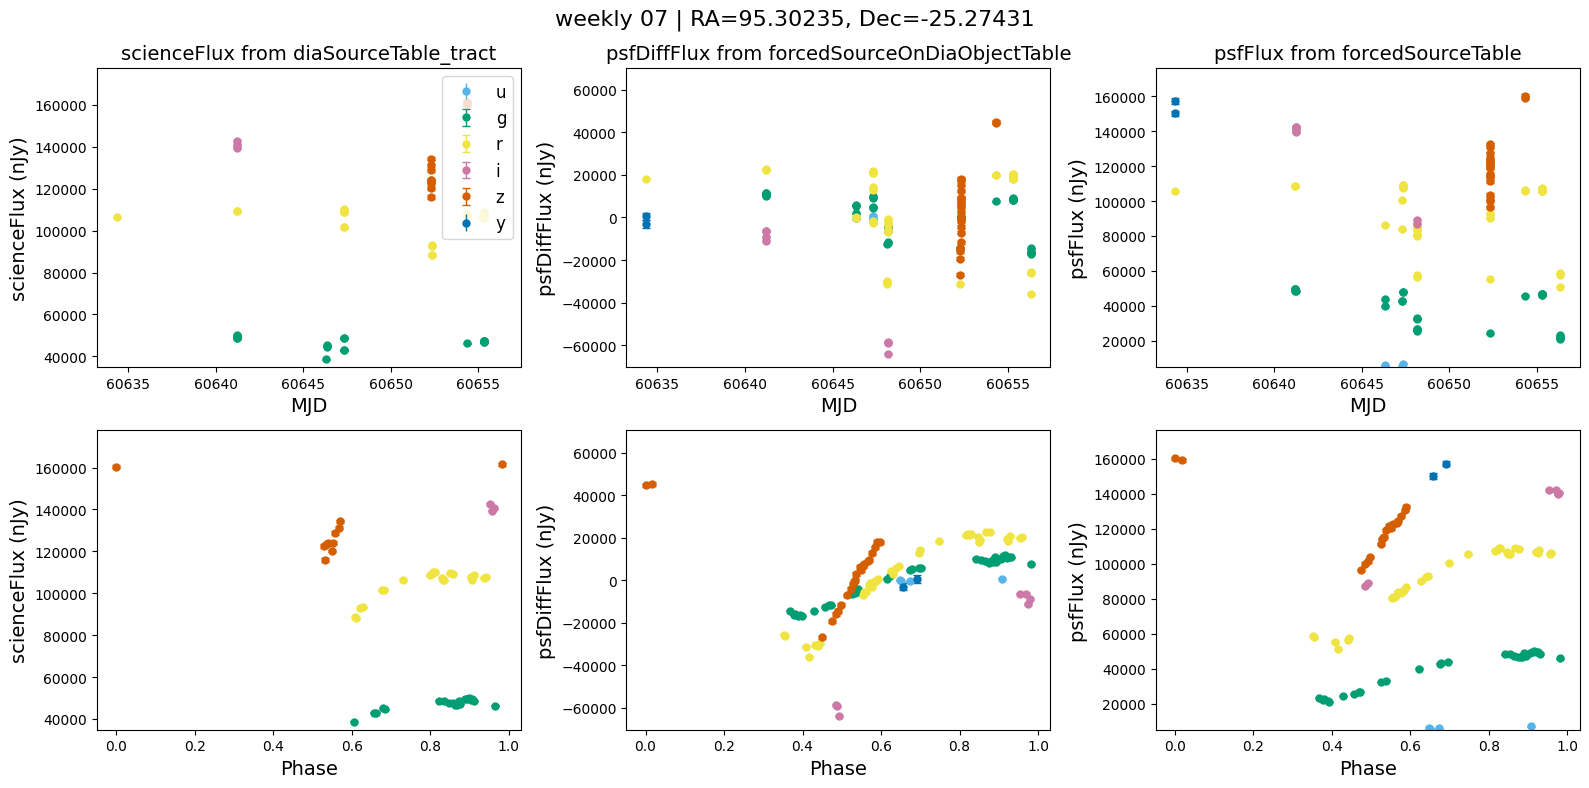

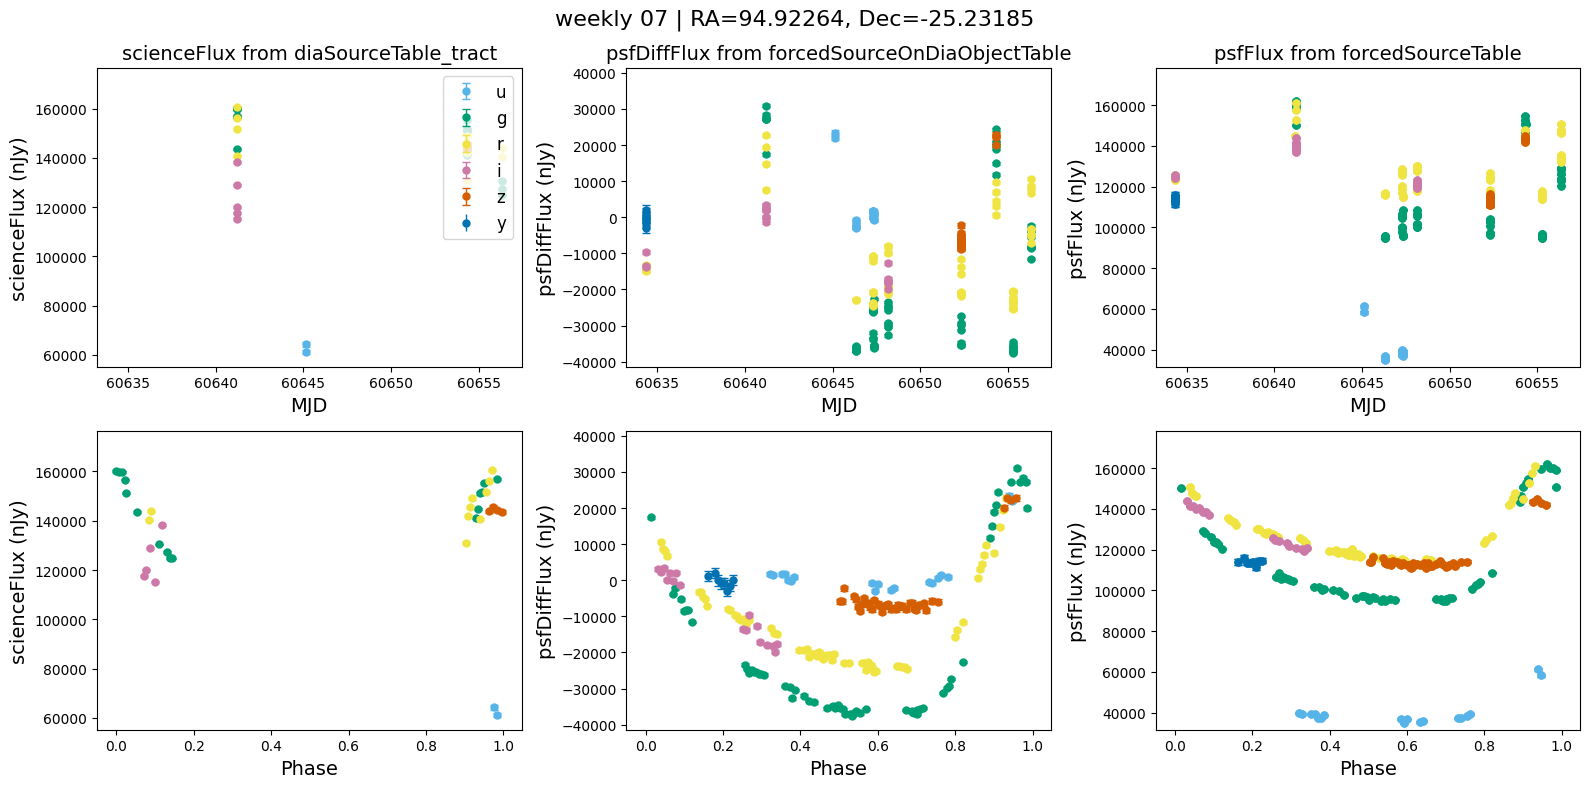

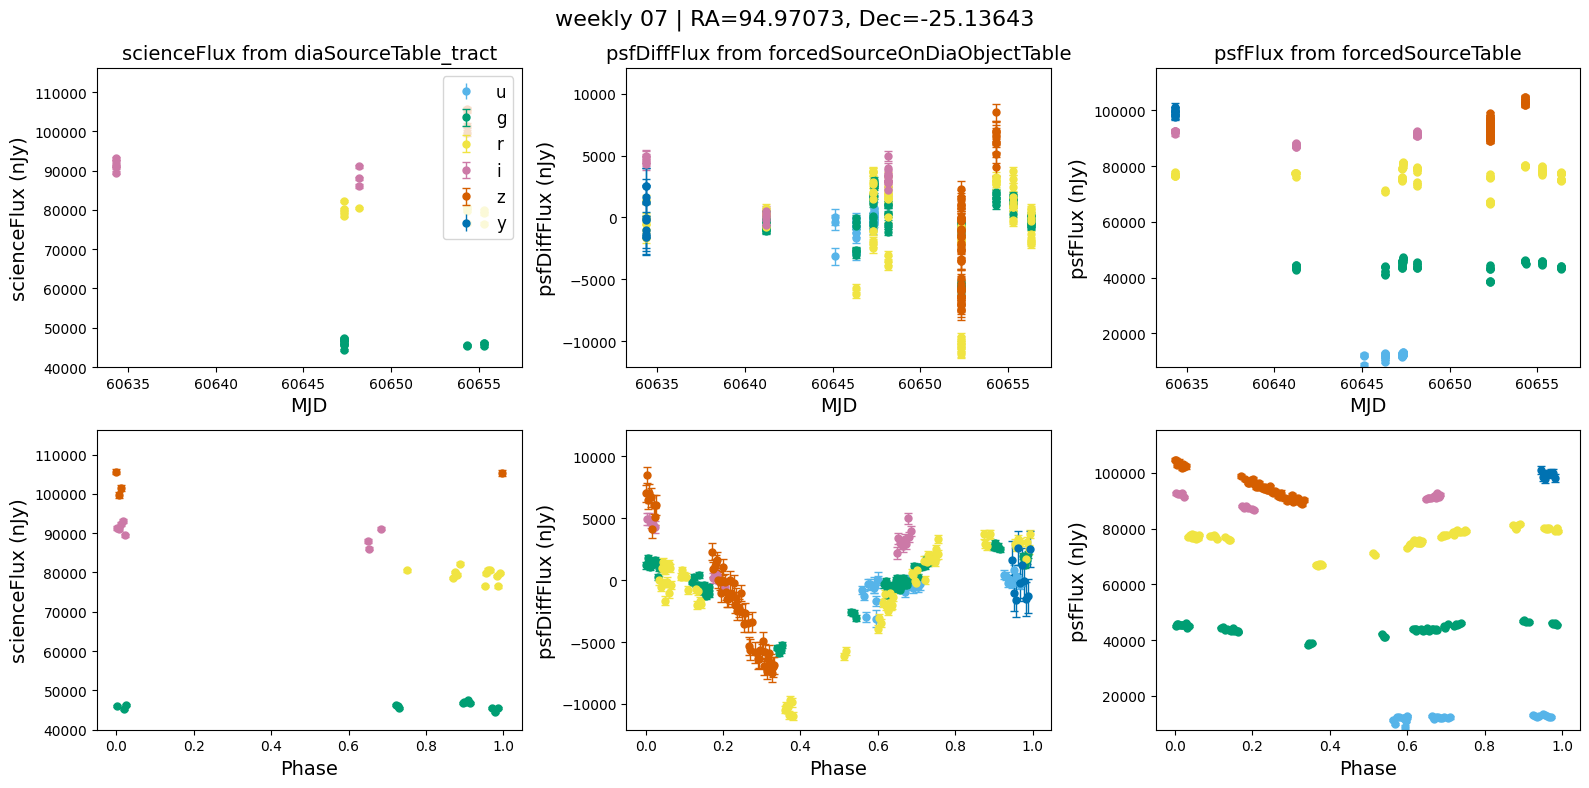

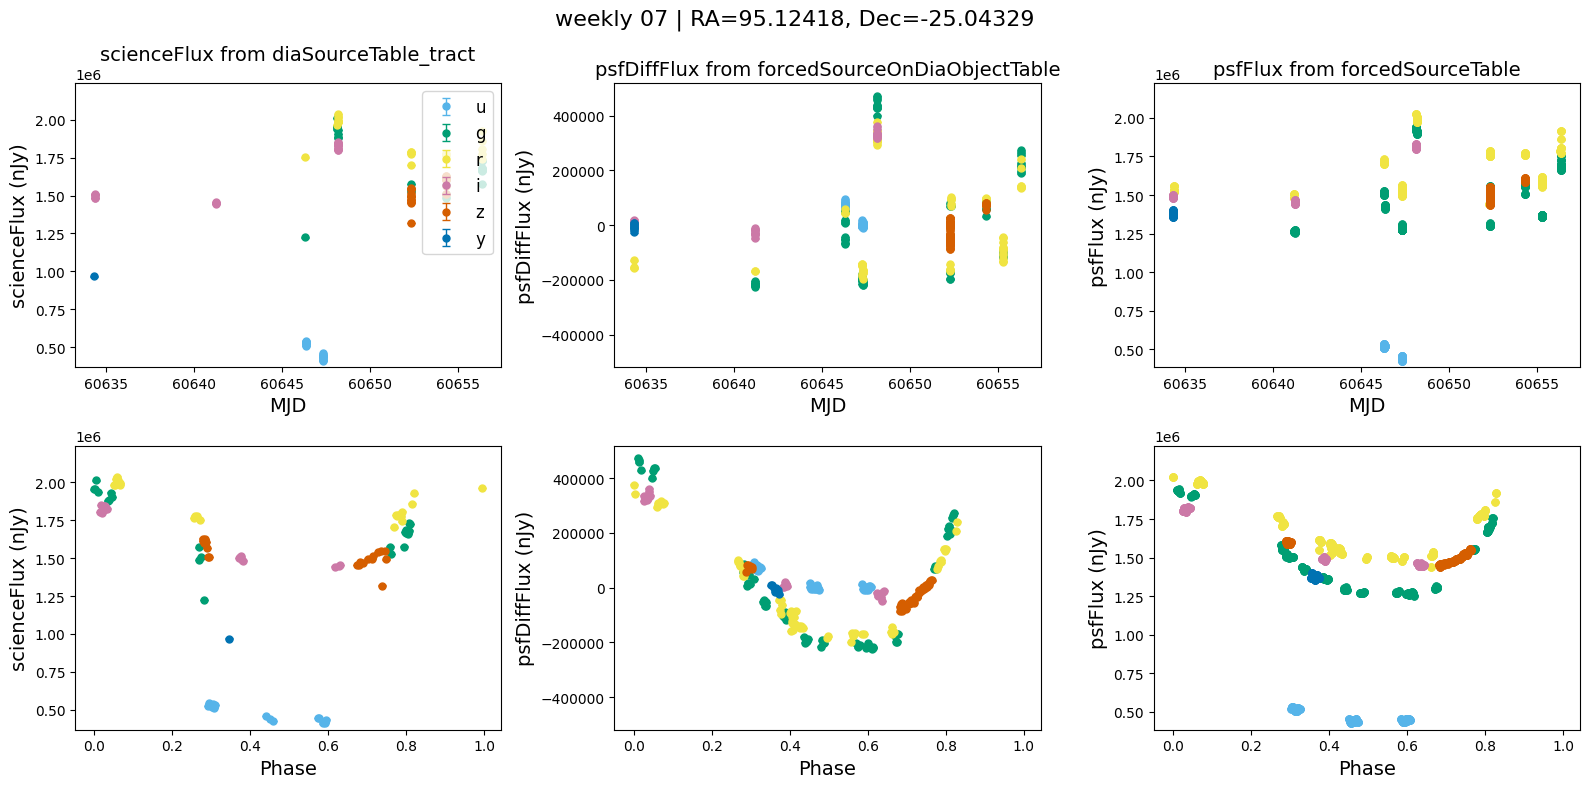

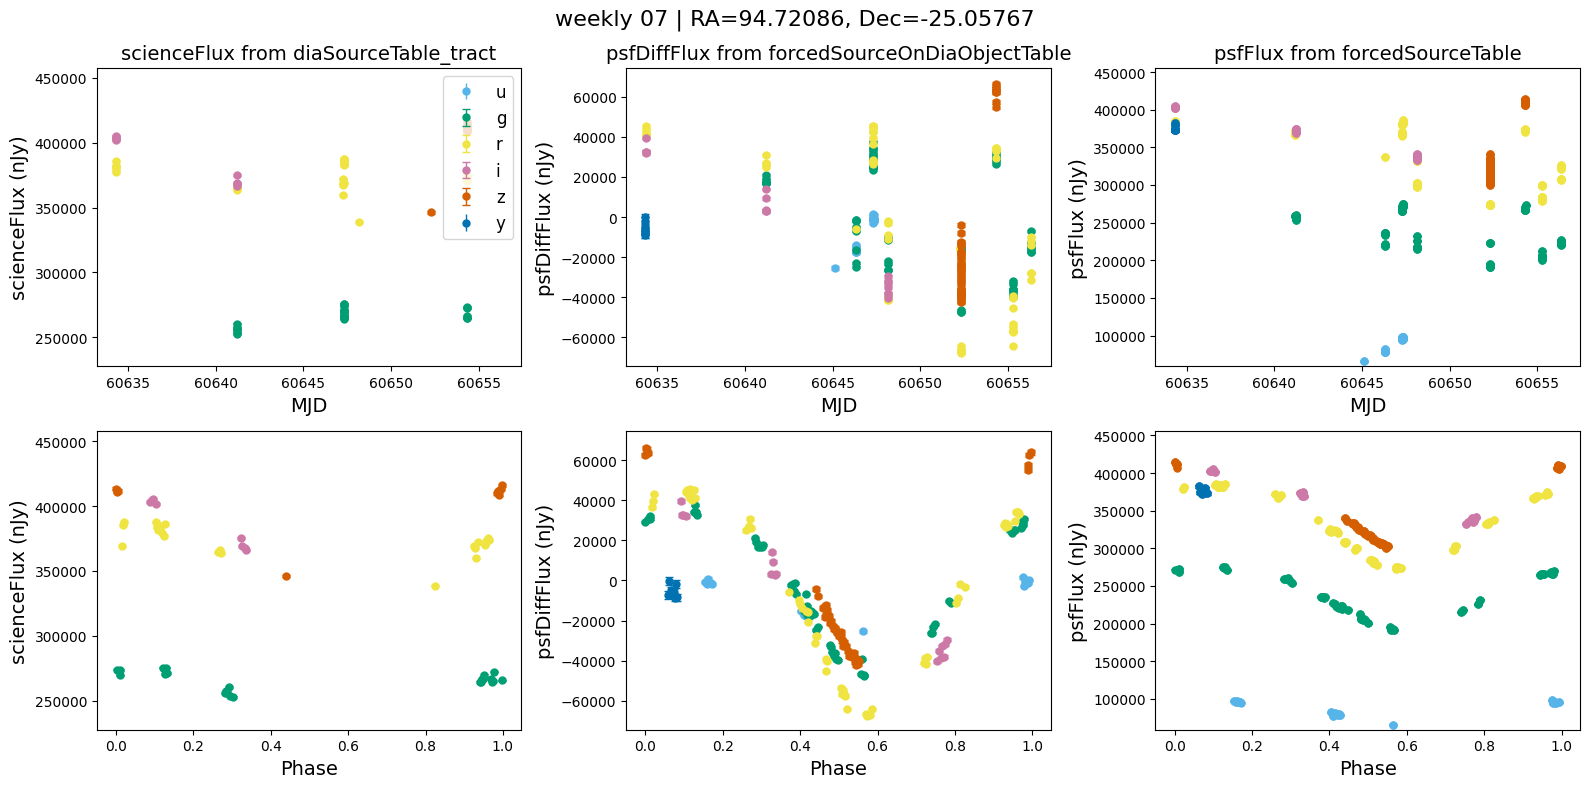

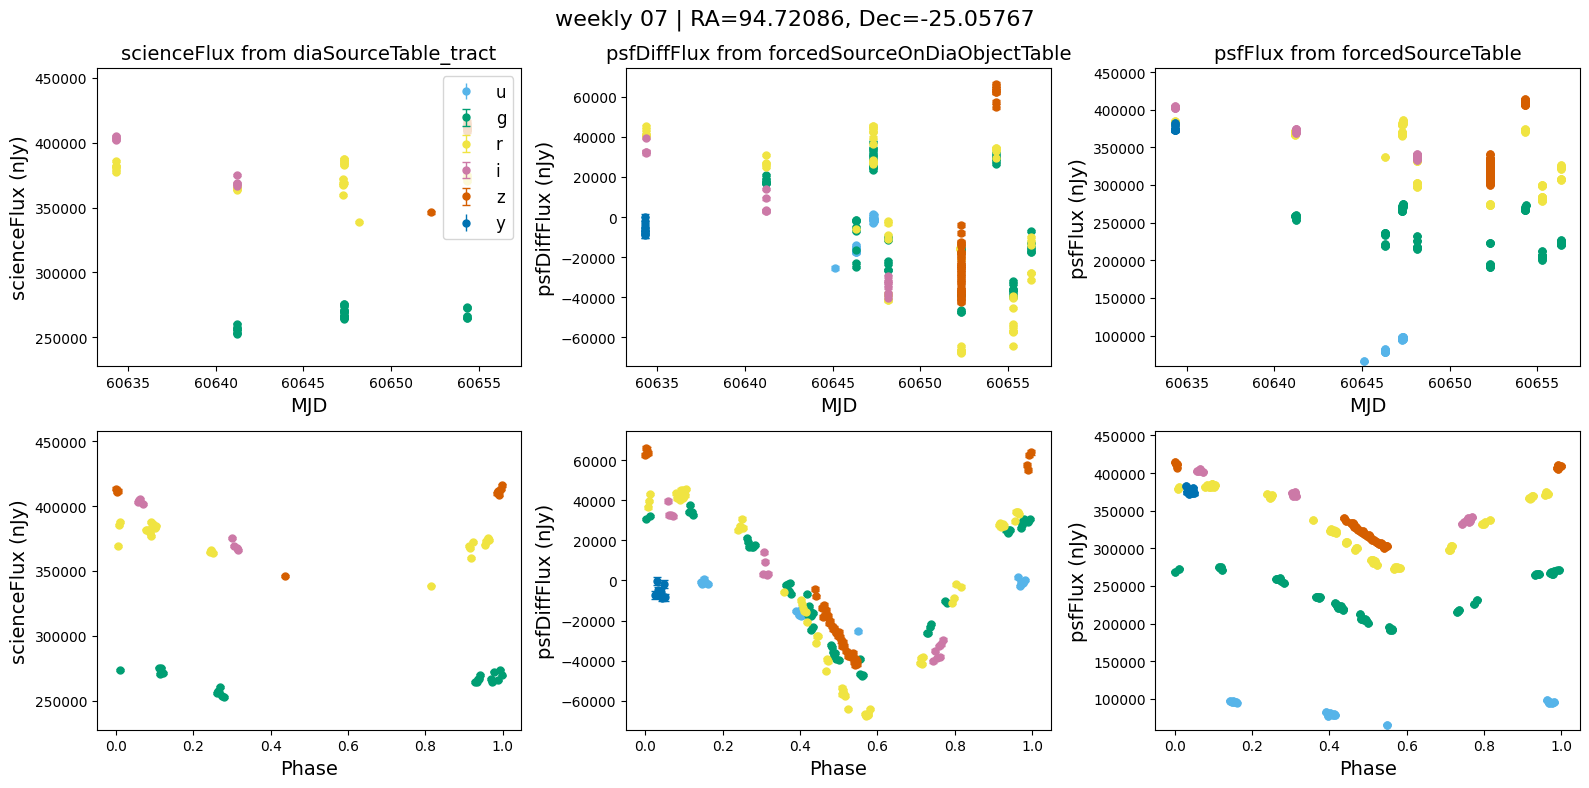

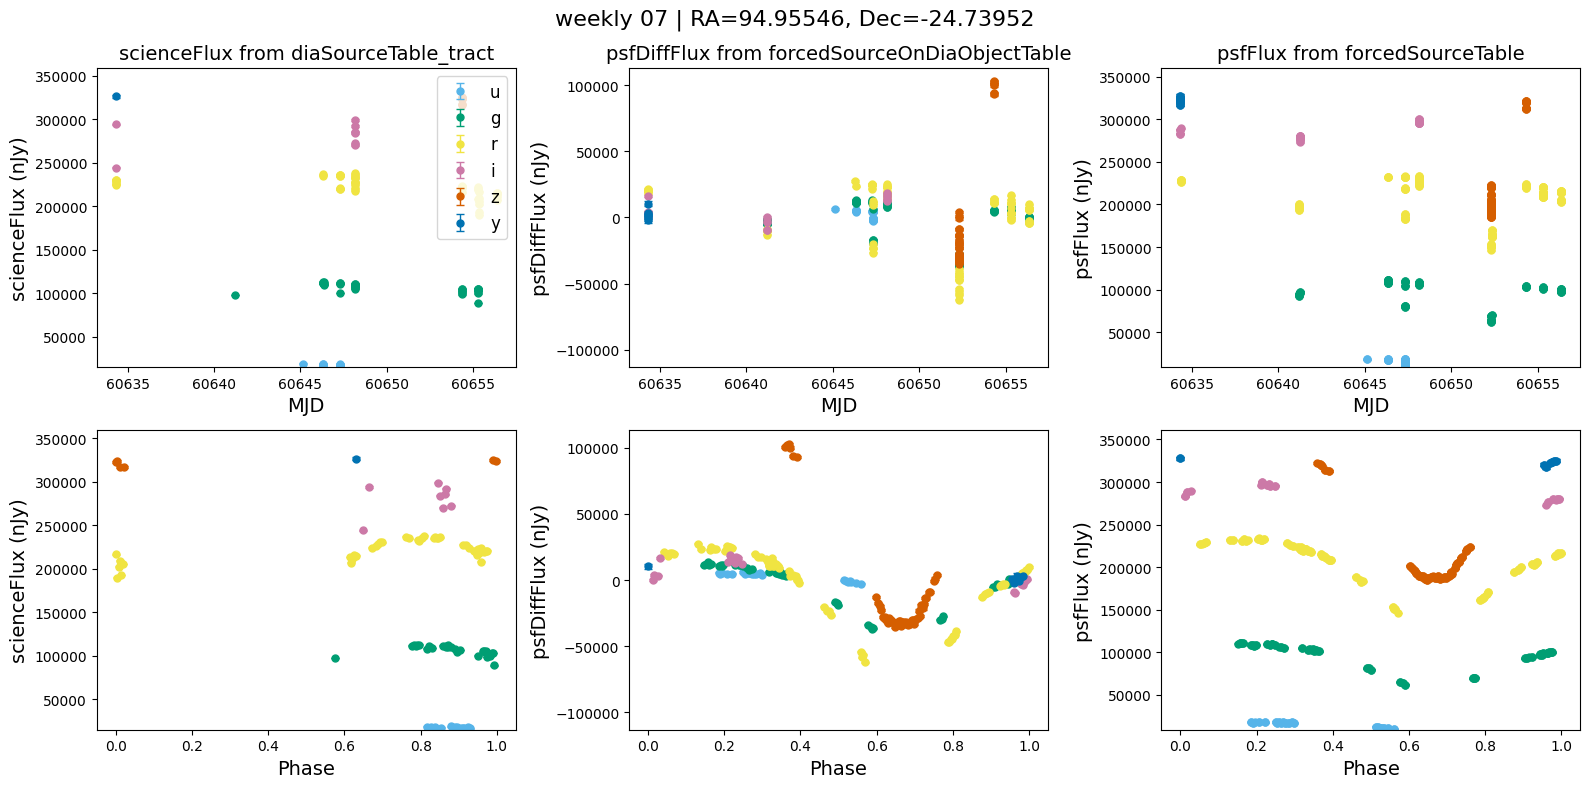

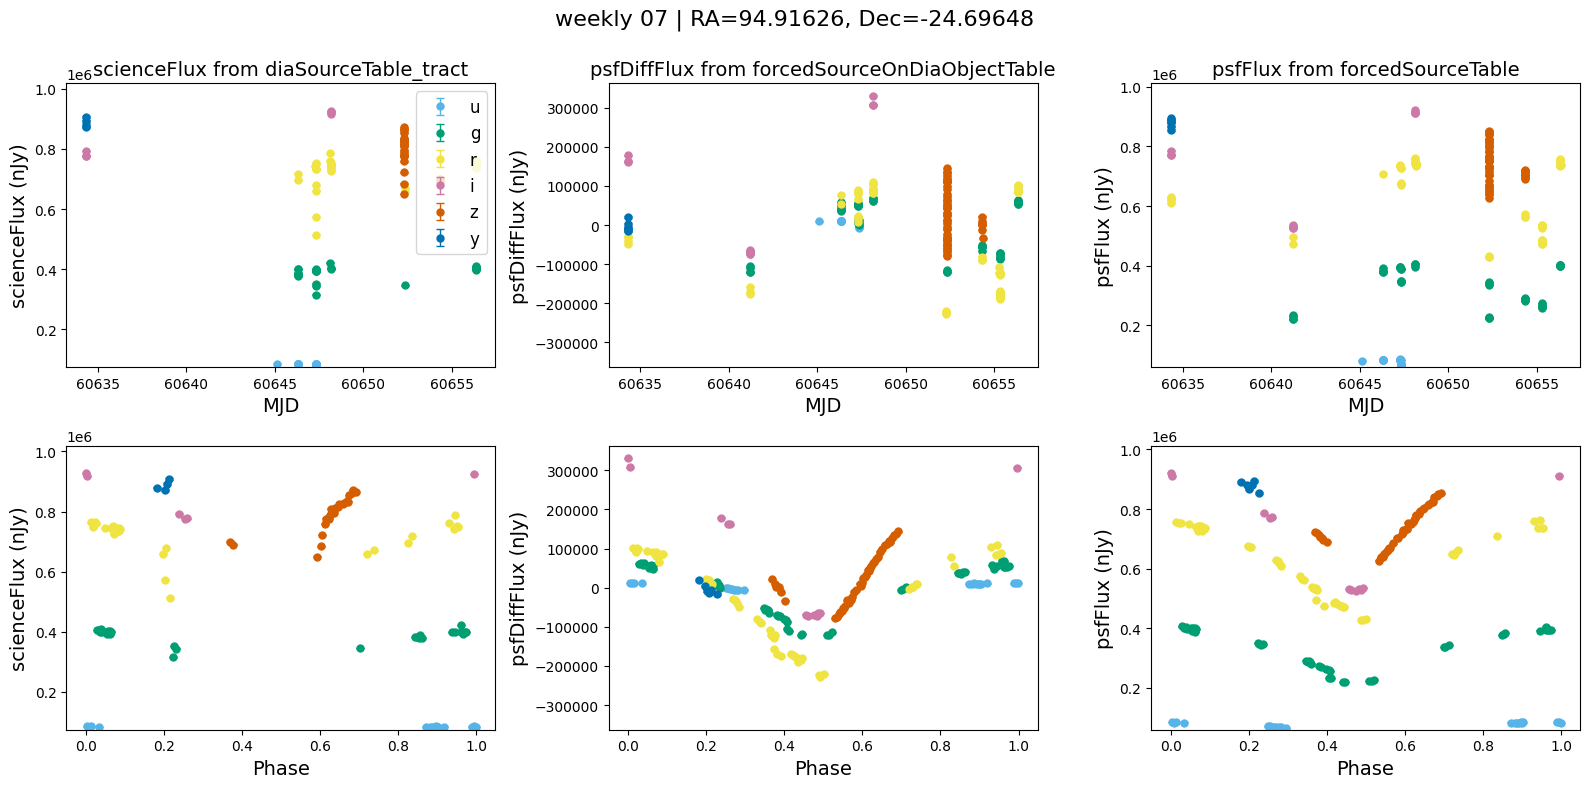

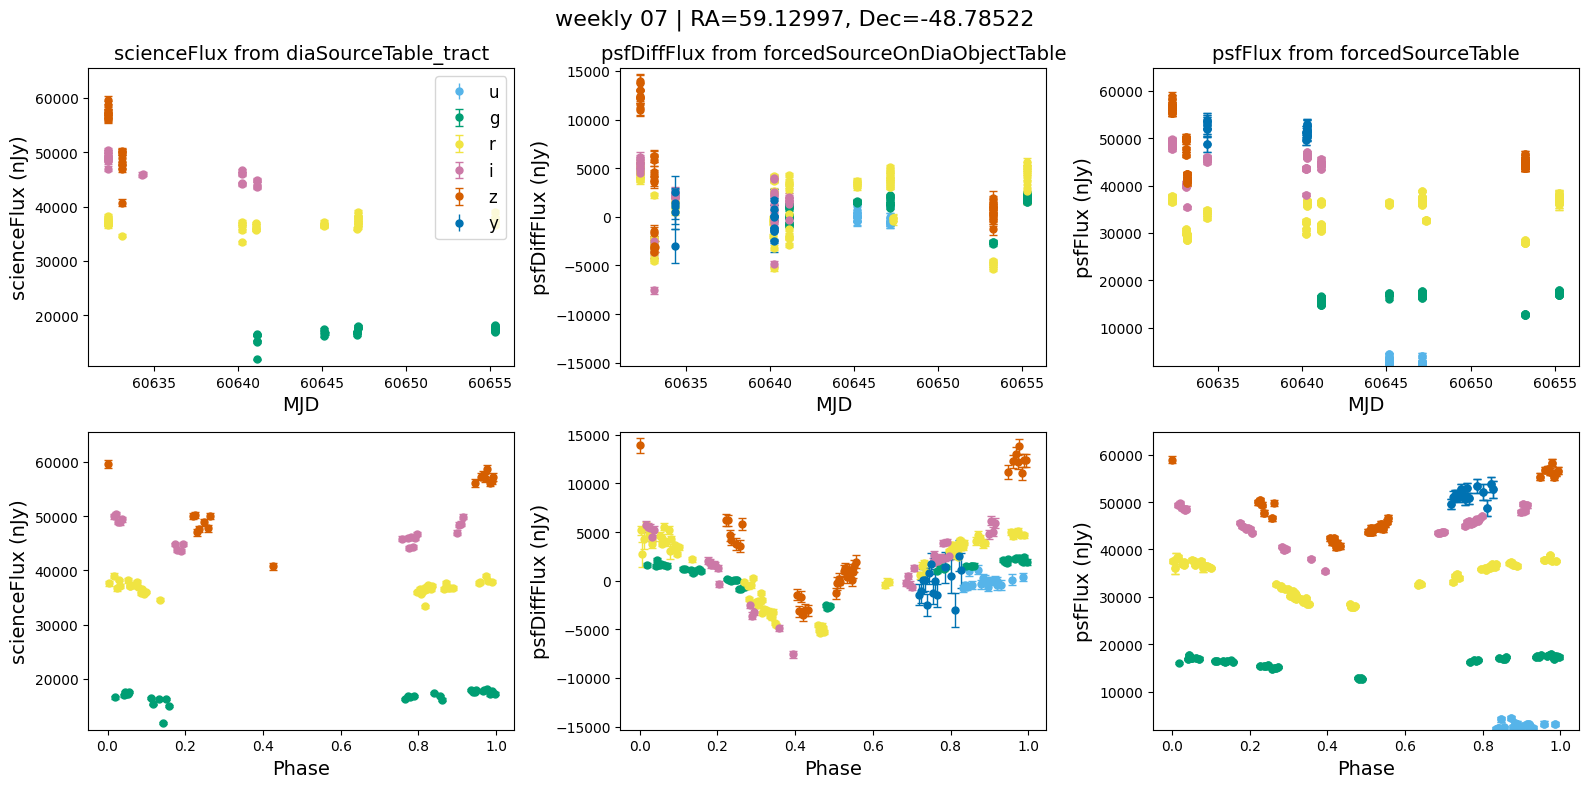

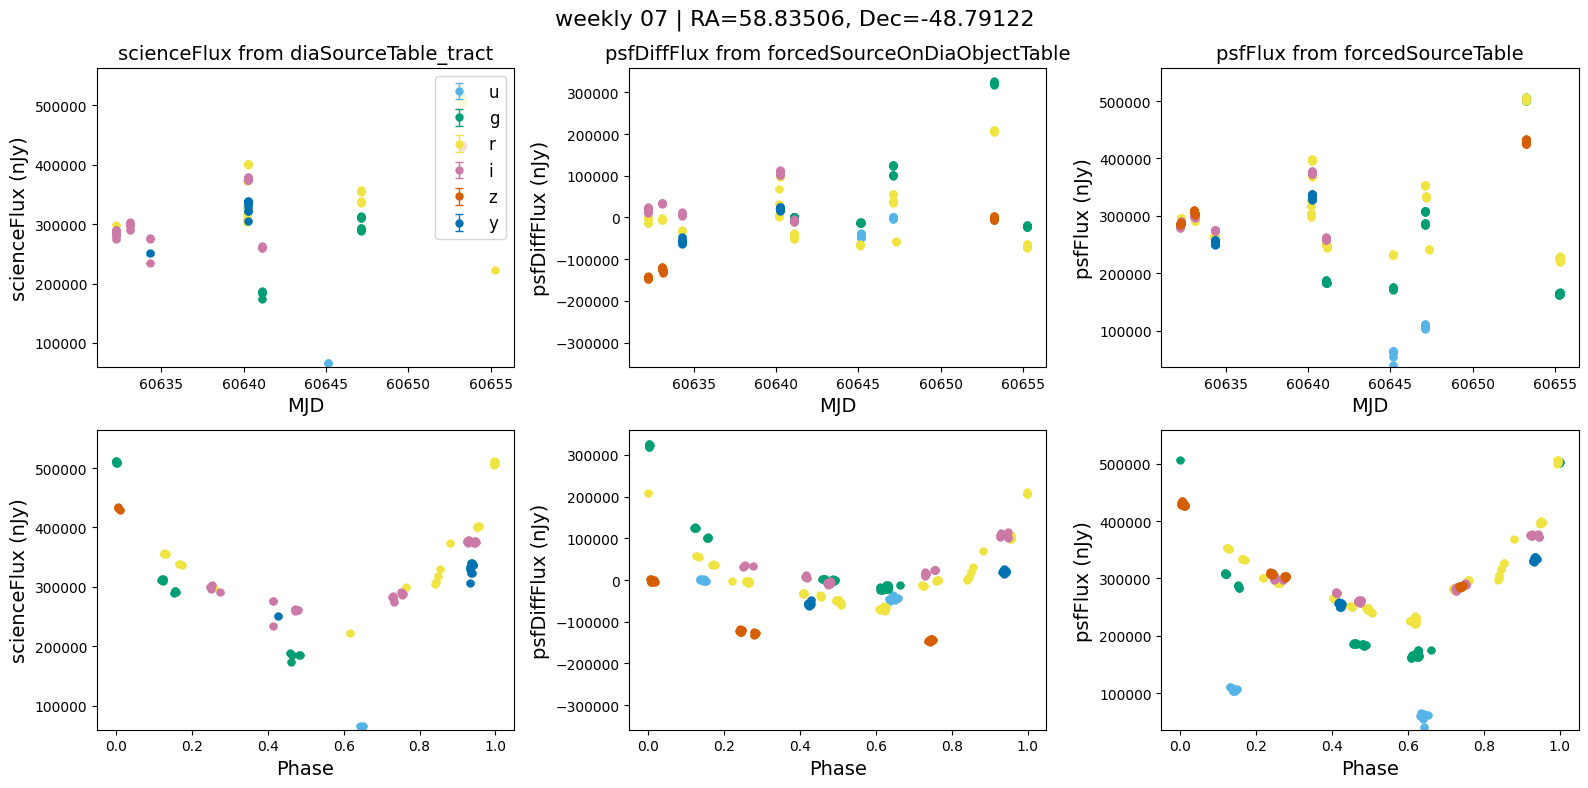

In [16]:
import numpy as np
import matplotlib.pyplot as plt

COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

# Function to plot light curves in flux scale
def plot(ax, lc, flux_col, flux_err_col, x_name="midpointMjdTai", x_label="MJD", show_legend=False):
    lc = lc.query(
        "~psfFlux_flag"
        " and ~pixelFlags_saturated"
        " and ~pixelFlags_cr"
        " and ~pixelFlags_bad"
    )

    flux_values = []  # Store flux values for setting axis limits

    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        
        # Extract flux values and errors directly
        flux = band_lc[flux_col]
        flux_err = band_lc[flux_err_col]

        ax.errorbar(
            band_lc[x_name], flux, flux_err,
            fmt='o', label=band, color=color, alpha=1, markersize=5, capsize=3, elinewidth=1
        )

        flux_values.extend(flux.dropna().values)  # Collect flux values

    ax.set_xlabel(x_label, fontsize=14)  # Increased font size
    ax.set_ylabel(f"{flux_col} (nJy)", fontsize=14)  # Increased font size

    if show_legend:
        ax.legend(loc="upper right", fontsize=12)  # Show legend in top-left panel only

    return flux_values  # Return flux values for axis scaling


for _, row in df.iterrows():
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex="row")  # 2 rows, 3 columns

    fig.suptitle(f"weekly 07 | RA={row.ra_nice_obj:.5f}, Dec={row.dec_nice_obj:.5f}", fontsize=16)  # Increased font size

    all_flux = [[], [], []]  # To store flux values for each column separately

    # Define flux types for each dataset
    datasets = [
        ("scienceFlux", "scienceFluxErr", "scienceFlux from diaSourceTable_tract", row.diaSource),  # Column 1
        ("psfDiffFlux", "psfDiffFluxErr", "psfDiffFlux from forcedSourceOnDiaObjectTable", row.diaForcedSource),  # Column 2
        ("psfFlux", "psfFluxErr", "psfFlux from forcedSourceTable", row.forcedSource),  # Column 3
    ]

    for i, (flux_col, flux_err_col, title, lc) in enumerate(datasets):
        ax[0, i].set_title(title, fontsize=14)  # Increased font size for titles

        # Compute phase
        lc = lc.assign(phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()]) 
                       % row.Period_nice_obj / row.Period_nice_obj)

        # First row: original light curve
        all_flux[i].extend(plot(ax[0, i], lc, flux_col, flux_err_col, x_name="midpointMjdTai", x_label="MJD", show_legend=(i == 0)))  # Legend only in first panel

        # Second row: folded light curve
        all_flux[i].extend(plot(ax[1, i], lc, flux_col, flux_err_col, x_name="phase", x_label="Phase"))

    # Set uniform y-axis scaling for first and third columns, while middle remains independent and symmetric
    for row_idx in range(2):
        for col_idx in [0, 2]:  # Apply shared limits to first and third columns
            if all_flux[col_idx]:  # Ensure we have data
                ymin, ymax = np.nanmin(all_flux[col_idx]), np.nanmax(all_flux[col_idx])
                ax[row_idx, col_idx].set_ylim(ymin - 0.1 * abs(ymin), ymax + 0.1 * abs(ymax))  # Add buffer

        # Middle column (psfDiffFlux) gets independent, symmetric scaling
        if all_flux[1]:  
            max_abs_flux = np.nanmax(np.abs(all_flux[1]))  # Find the maximum absolute value
            ax[row_idx, 1].set_ylim(-max_abs_flux * 1.1, max_abs_flux * 1.1)  # Symmetric range around 0

    plt.tight_layout()
    plt.show()
